*   Автор решения: Тимур Камалиев
*   e-mail: timurkamaliev@gmail.com

**Задание 4.**	На сайте [Мирового Центра Данных по Солнечно-Земной Физике](http://www.wdcb.ru/stp/solar/sunspots.ru.html) имеется датасет с ежедневными измерениями числа солнечных пятен. На основе данных с 1944 г по наст. вр. необходимо создать и обучить предиктивную модель, выдающую прогноз числа солнечных пятен на сроки 1, 10 и 30 дней от требуемой даты. Обосновать выбор модели и ее гиперпараметров и оценить качество полученных результатов.

In [142]:
# Необходима библиотека statsmodels версии 0.12.2
# !pip install statsmodels --upgrade

In [143]:
import numpy as np
import pandas as pd
import datetime
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as fnn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

matplotlib_axes_logger.setLevel('ERROR')
sns.set_style('whitegrid'),
sns.set_palette('colorblind')
palette = sns.color_palette()

### Чтение и подготовка исходных данных

In [144]:
data = pd.read_csv('http://www.wdcb.ru/stp/data/solar.act/sunspot/AAVSO/daily/plt_daily.txt', delim_whitespace=True, header=1)
data.head()

,Year,Month,Day,Ra
0,1945,1,1,10
1,1945,1,2,0
2,1945,1,3,1
3,1945,1,4,2
4,1945,1,5,11


In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27759 entries, 0 to 27758
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year    27759 non-null  int64
 1   Month   27759 non-null  int64
 2   Day     27759 non-null  int64
 3   Ra      27759 non-null  int64
dtypes: int64(4)
memory usage: 867.6 KB


Сформируем колонку с временными метками.

In [146]:
data['Time'] = pd.to_datetime(data[["Year", "Month", "Day"]])
data.head()

,Year,Month,Day,Ra,Time
0,1945,1,1,10,1945-01-01
1,1945,1,2,0,1945-01-02
2,1945,1,3,1,1945-01-03
3,1945,1,4,2,1945-01-04
4,1945,1,5,11,1945-01-05


### Анализ данных

Визуализируем исходные данные.

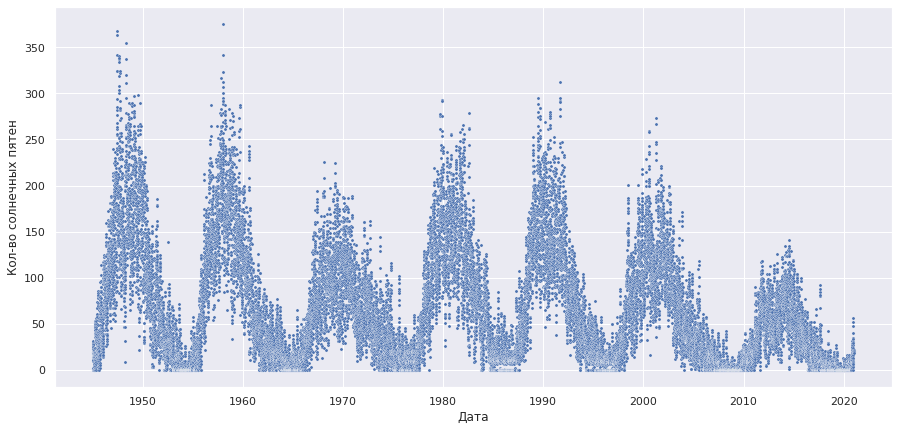

In [147]:
sns.set(rc={'figure.figsize': (15, 7)})
ax = sns.scatterplot(data=data, x='Time', y='Ra', s=10)
ax.set(xlabel='Дата', ylabel='Кол-во солнечных пятен');

График появления солнечных пятен представлет собой временной ряд, который имеет определенную цикличность: визуально заметно, что примерно каждые 11-12 лет наблюдается всплеск активности. При этом предыдущий наблюдаемый пик меньше по амплитуде, чем остальные.

Прежде, чем перейти к построению моделей, необходимо убедиться, что в данном временном ряде присутствует связь между прошлыми и будущими его значениями.

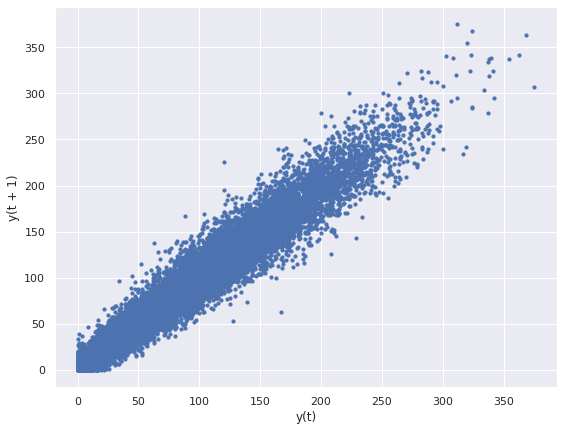

In [148]:
X = data[['Time', 'Ra']].copy()
X.set_index('Time', inplace=True)
sns.set(rc={'figure.figsize': (9, 7)})
lag_plot(X, s=10);

In [149]:
df = pd.concat([X.shift(1), X], axis=1)
df.columns = ['t-1', 't+1']
result = df.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.978709
t+1  0.978709  1.000000


Для того, чтобы выявить периодичность во временных рядах, построим график автокорреляции, который показывает значание автокорреляции для разных временных лагов.

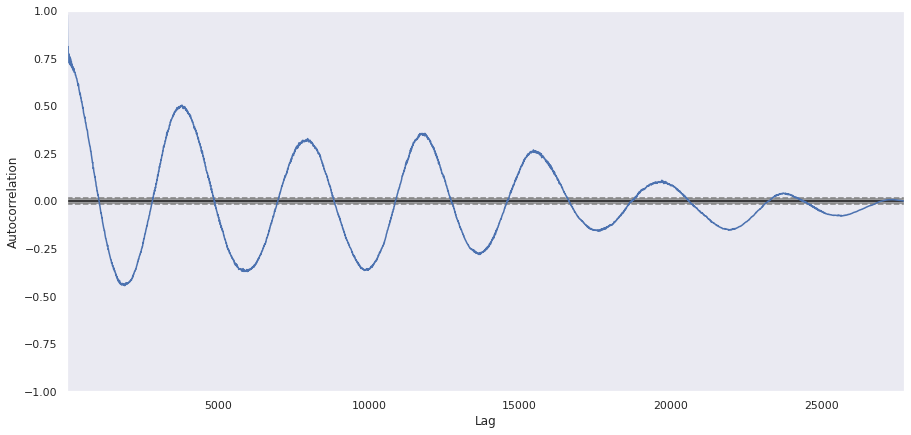

In [150]:
sns.set(rc={'figure.figsize': (15, 7)})
autocorrelation_plot(X);

In [151]:
X['Ra'].corr(X['Ra'].shift(10))

0.7452633321984957

Теперь построим графики ACF (функция автокорреляции) и PACF (частичная автокорреляционная фукнция), используя возможности библиотеки `statsmodels`.

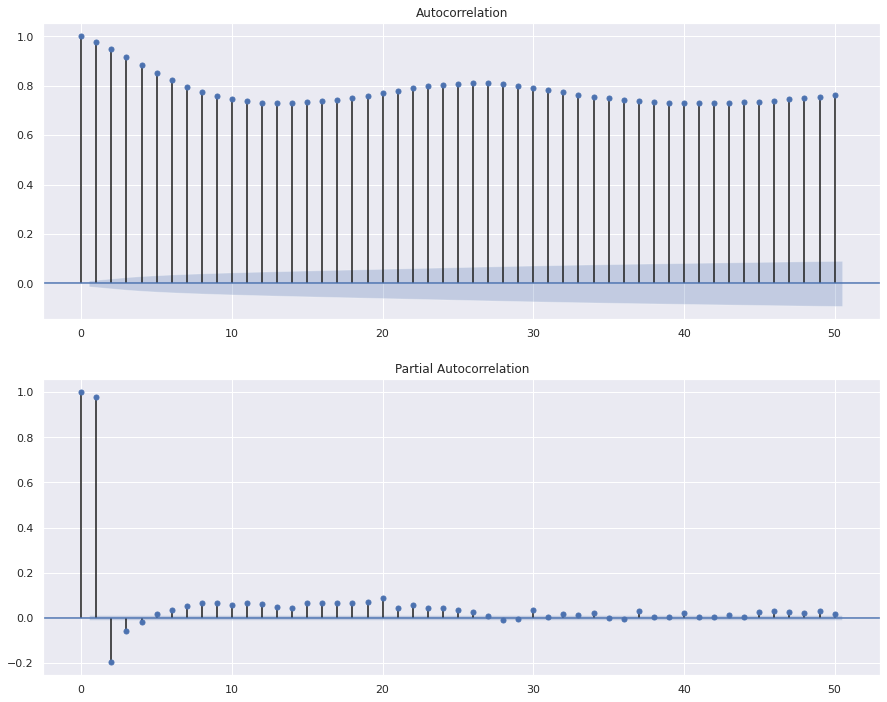

In [152]:
sns.set(rc={'figure.figsize': (15, 12)})
fig, ax = plt.subplots(2, 1)
plot_acf(X, lags=50, ax=ax[0]);
plot_pacf(X, lags=50, ax=ax[1]);

Увеличим масштаб данных и посмотрим на ежемесячные наблюдения. Построим графики ACF и PACF.

In [153]:
X_month = X.resample('M').mean()
X_month

,Ra
Time,
1945-01-31,18.548387
1945-02-28,11.785714
1945-03-31,19.677419
1945-04-30,31.633333
1945-05-31,26.612903
...,...
2020-08-31,5.290323
2020-09-30,0.366667
2020-10-31,9.935484


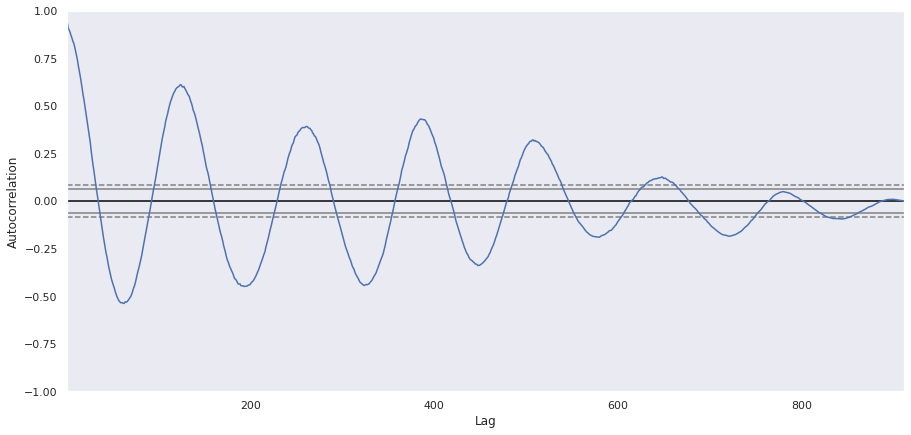

In [154]:
sns.set(rc={'figure.figsize': (15, 7)})
autocorrelation_plot(X_month);

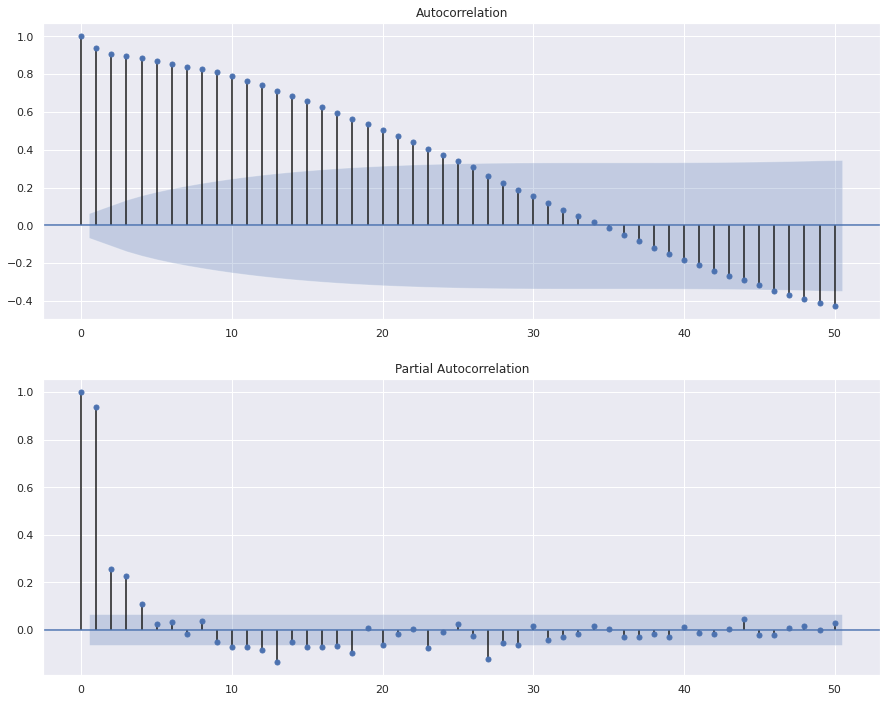

In [155]:
sns.set(rc={'figure.figsize': (15, 12)})
fig, ax = plt.subplots(2, 1)
plot_acf(X_month, lags=50, ax=ax[0]);
plot_pacf(X_month, lags=50, ax=ax[1]);

Также выполним проверку временного ряда на стационарность. Для этого можно воспользоваться тестом Дики—Фуллера (ADF-тест).

In [156]:
ADF_test = adfuller(X)
print('ADF: ', ADF_test[0])
print('p-value: ', ADF_test[1])
print('Критические значения: ', ADF_test[4])
if ADF_test[0] > ADF_test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен.')
else:
    print('Единичных корней нет, ряд стационарен.')

ADF:  -4.735518575790278
p-value:  7.213177250327938e-05
Критические значения:  {'1%': -3.4305860210003756, '5%': -2.861644314585676, '10%': -2.56682552352575}
Единичных корней нет, ряд стационарен.


Перед тем, как перейти к построению моделей, разобъем исходную выборку на обучающую и тестовую части.

In [157]:
split_date = '2002-01-01'
split_index = np.where(X.index==split_date)[0][0]
train, test = X[1:split_index], X[split_index:]

In [158]:
# Вспомогательная функция для визуализации результатов обучения
def plot_result(train_data, test_data, prediction, model_name): 
    sns.set(rc={'figure.figsize': (15, 7)})
    fig, ax = plt.subplots(1)
    fig.set_figheight(7)
    fig.set_figwidth(15)
    ax.scatter(train_data.index, train_data['Ra'], s=10, label='Обучающая')
    ax.scatter(test_data.index, test_data['Ra'], s=10, label='Тестовая')
    ax.plot(test_data.index, prediction, c='green', label=model_name)
    plt.legend(loc='best') 
    plt.title('Предсказания по модели ' + model_name) 
    plt.xlabel('Дата', fontsize=12, fontweight='bold', color='gray')
    plt.ylabel('Кол-во солнечных пятен', fontsize=12, fontweight='bold', color='gray');

### Построение моделей временного ряда

Основной способ моделирования временных рядов заключается в применении различных регрессионных моделей. В рамках данной задачи буду рассмотрены следующие модели:

*   Autoregression
*   ARIMA
*   SARIMA
*   Facebook Prophet

Также посмотрим, как с этой задачей справится модель на основе НС.

В качестве метрики выберем MSE и MAE.


#### Autoregression

Построим авторегрессионную модель на ежедневных данных.

In [171]:
# Подберем список временных лагов
AR_lags = [1, 10, 25, 50, 100, 150, 200, 300, 500, 1800, 3800, 5500]
test_range = []
for i in AR_lags:
    test_range.append(i)
    model_AR = AutoReg(train, lags=test_range, old_names=False);
    model_AR = model_AR.fit()
    pred_AR = model_AR.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    mse_AR = mean_squared_error(test, pred_AR, squared=True)
    mae_AR = mean_absolute_error(test, pred_AR)
    print('Added lag {0}:\tMSE = {1:.3f},\tMAE = {2:.3f}'.format(i, mse_AR, mae_AR));

Added lag 1:	MSE = 3181.982,	MAE = 50.633
Added lag 10:	MSE = 3181.459,	MAE = 50.626
Added lag 25:	MSE = 3262.843,	MAE = 51.414
Added lag 50:	MSE = 3497.929,	MAE = 53.570
Added lag 100:	MSE = 4061.801,	MAE = 58.145
Added lag 150:	MSE = 4822.712,	MAE = 63.659
Added lag 200:	MSE = 4787.343,	MAE = 63.398
Added lag 300:	MSE = 4753.758,	MAE = 63.135
Added lag 500:	MSE = 4020.292,	MAE = 57.895
Added lag 1800:	MSE = 2223.600,	MAE = 42.994
Added lag 3800:	MSE = 2161.816,	MAE = 42.341
Added lag 5500:	MSE = 1899.903,	MAE = 38.169


In [172]:
%%time
model_AR = AutoReg(train, lags=AR_lags, old_names=False).fit()

CPU times: user 3.62 s, sys: 110 ms, total: 3.73 s
Wall time: 3.68 s


In [173]:
print('Коэффициенты модели: ', model_AR.params)

Коэффициенты модели:  const       1.588366
Ra.L1       0.927013
Ra.L10     -0.029181
Ra.L25      0.038231
Ra.L50      0.025597
Ra.L100     0.011412
Ra.L150     0.009261
Ra.L200    -0.000008
Ra.L300     0.003939
Ra.L500    -0.001255
Ra.L1800   -0.005802
Ra.L3800    0.002447
Ra.L5500   -0.003933
dtype: float64


In [174]:
pred_AR = model_AR.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [175]:
mse_AR = mean_squared_error(test, pred_AR, squared=True)
mae_AR = mean_absolute_error(test, pred_AR)
print('Ошибки прогноза по модели AutoReg: MSE = {0:.3f}, MAE = {1:.3f}.'.format(mse_AR, mae_AR));

Ошибки прогноза по модели AutoReg: MSE = 1899.903, MAE = 38.169.


Визуализируем прогноз авторегрессионной модели на тестовой выборке.

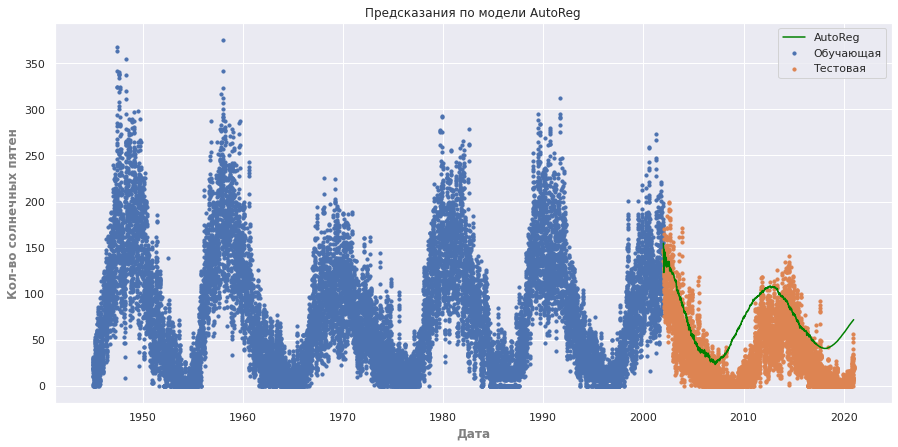

In [176]:
plot_result(train, test, pred_AR, 'AutoReg')

В целом, модель дает неплохой прогноз: амплитуда пика примерно соответствует набору исторических точек, однако период отличается от реального.

Перейдем к следующей модели - ARIMA.

#### ARIMA

In [ ]:
%%time
model_ARIMA = ARIMA(train, order=(3, 0, 10)).fit();

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 2min 30s, sys: 1min 50s, total: 4min 21s
Wall time: 2min 25s


In [ ]:
print(model_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                     Ra   No. Observations:                20818
Model:                ARIMA(3, 0, 10)   Log Likelihood              -83529.755
Date:                Mon, 22 Mar 2021   AIC                         167089.510
Time:                        04:28:10   BIC                         167208.664
Sample:                    01-02-1945   HQIC                        167128.418
                         - 12-31-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.3823     18.636      4.152      0.000      40.857     113.908
ar.L1         -0.4444      0.040    -11.040      0.000      -0.523      -0.366
ar.L2          0.7168      0.026     28.087      0.0

In [ ]:
pred_ARIMA = model_ARIMA.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

In [ ]:
mse_ARIMA = mean_squared_error(test, pred_ARIMA, squared=True)
mae_ARIMA = mean_absolute_error(test, pred_ARIMA)
print('Ошибки прогноза: MSE = {0:.3f}, MAE = {1:.3f}'.format(mse_ARIMA, mae_ARIMA));

Ошибки прогноза: MSE = 3760.238, MAE = 55.776


Построим график прогноза.

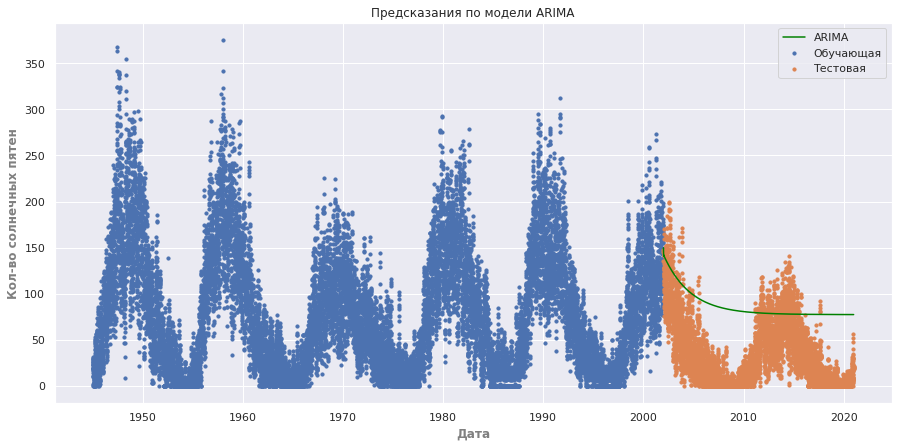

In [ ]:
plot_result(train, test, pred_ARIMA, 'ARIMA')

Модель демонстрирует менее качественный прогноз по сравнению с предыдущей. 

#### SARIMA

Теперь постараемся учесть в модели сезонные колебания.

Учитывая вычислительную сложность, данную модель будем строить на ежемесячных данных.

In [ ]:
train_month = train.resample('M').last()
test_month = test.resample('M').last()

In [ ]:
%%time
model_SARIMA = SARIMAX(train_month, trend='n', order=(3, 0, 10), seasonal_order=(1, 1, 0, 65)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 7min 11s, sys: 2min 41s, total: 9min 53s
Wall time: 5min 4s


In [ ]:
print(model_SARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                   Ra   No. Observations:                  684
Model:             SARIMAX(3, 0, 10)x(1, 1, [], 65)   Log Likelihood               -3207.526
Date:                              Mon, 22 Mar 2021   AIC                           6445.051
Time:                                      04:57:13   BIC                           6511.473
Sample:                                  01-31-1945   HQIC                          6470.872
                                       - 12-31-2001                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9917      0.316      3.142      0.002       0.373       1.610
ar.L2          0.99

In [ ]:
pred_SARIMA = model_SARIMA.predict(start=len(train_month), end=len(train_month)+len(test_month)-1, dynamic=True)

In [ ]:
mse_SARIMA = mean_squared_error(test_month, pred_SARIMA, squared=True)
mae_SARIMA = mean_absolute_error(test_month, pred_SARIMA)
print('Ошибки прогноза: MSE = {0:.3f}, MAE = {1:.3f}'.format(mse_SARIMA, mae_SARIMA));

Ошибки прогноза: MSE = 3016.956, MAE = 45.083


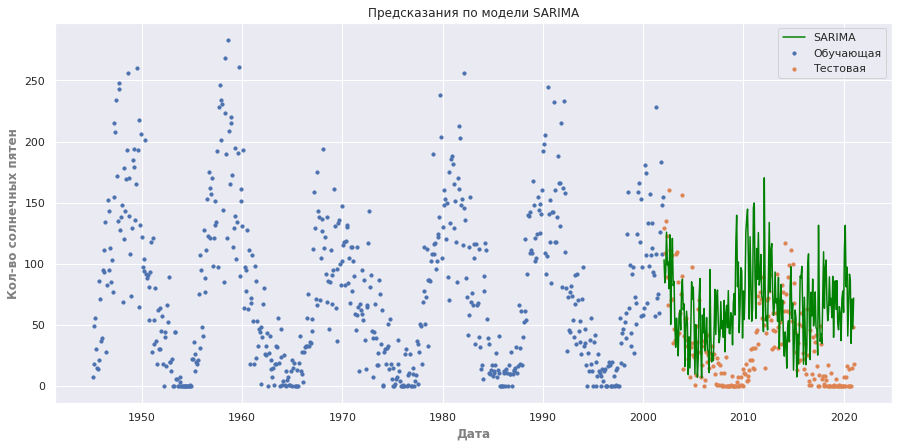

In [ ]:
plot_result(train_month, test_month, pred_SARIMA, 'SARIMA')

Из приведенного графика видно, что прогноз по модели SARIMA получился достаточно "шумным" и время окончания текущего и начала следующего цикла по-прежнему определяется не совсем точно.

#### FbProphet

Перейдем к модели Facebook Prophet.
Данная модель работает с датафреймами с фиксированным наименованием колонок. Для этого создадим копию исходных данных и в рамках этой модели будем работать с ней.

In [ ]:
data_prophet = data[['Time', 'Ra']].copy()
data_prophet.columns = ['ds','y']
data_prophet.tail()

,ds,y
27754,2020-12-27,22
27755,2020-12-28,19
27756,2020-12-29,21
27757,2020-12-30,20
27758,2020-12-31,18


На этих данных попробуем построить прогноз по модель "из коробки" и визуализировать полученный результат.

In [ ]:
split_date = datetime.datetime(2002, 1, 1)
train_prophet = data_prophet.set_index('ds')[:split_date].iloc[:-1,].reset_index()
test_prophet = data_prophet.set_index('ds')[split_date:].reset_index()

In [ ]:
%%time
model_prophet = Prophet(weekly_seasonality=False, daily_seasonality=False).fit(train_prophet);

CPU times: user 46.4 s, sys: 366 ms, total: 46.8 s
Wall time: 46.8 s


In [ ]:
pred_period = len(pd.date_range(split_date, max(data_prophet['ds'])))
dates_to_predict = model_prophet.make_future_dataframe(periods=pred_period, freq='d')
dates_to_predict.tail()

,ds
27754,2020-12-27
27755,2020-12-28
27756,2020-12-29
27757,2020-12-30
27758,2020-12-31


In [ ]:
%%time
pred_prophet = model_prophet.predict(dates_to_predict)

CPU times: user 23.6 s, sys: 13.1 s, total: 36.8 s
Wall time: 22.6 s


In [ ]:
pred_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27754,2020-12-27,12.575596,-1454.231336,1670.696770
27755,2020-12-28,11.974666,-1445.405296,1675.916814
27756,2020-12-29,11.399749,-1473.743305,1666.066251
27757,2020-12-30,10.862254,-1457.602199,1677.709878
27758,2020-12-31,10.372518,-1458.520123,1681.562812


In [159]:
y_hat = pred_prophet.set_index('ds')[split_date:].reset_index()['yhat']
mse_prophet = mean_squared_error(test_prophet['y'], y_hat, squared=True)
mae_prophet = mean_absolute_error(test_prophet['y'], y_hat)
print('Ошибки прогноза: MSE = {0:.3f}, MAE = {1:.3f}.'.format(mse_prophet, mae_prophet));

Ошибки прогноза: MSE = 1125.635, MAE = 27.731.


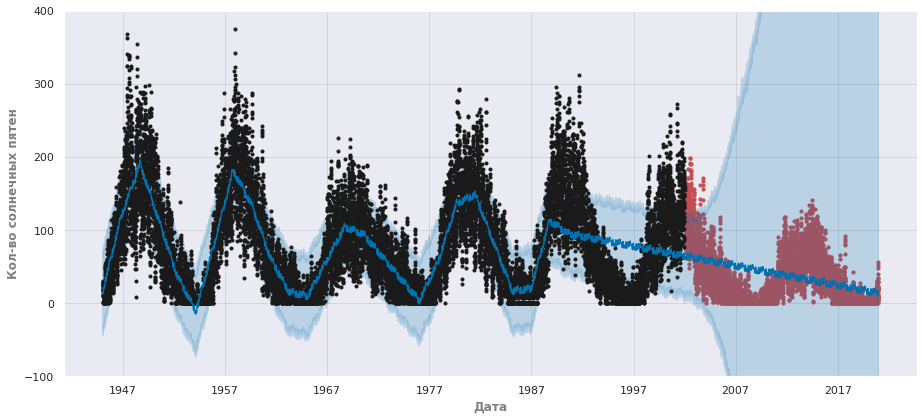

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(13)
ax.scatter(test_prophet['ds'], test_prophet['y'], color='r', s=10)
ax.set_ylim([-100, 400])
fig = model_prophet.plot(pred_prophet, ax=ax)
plt.xlabel('Дата', fontsize=12, fontweight='bold', color='gray')
plt.ylabel('Кол-во солнечных пятен', fontsize=12, fontweight='bold', color='gray')
plt.show()

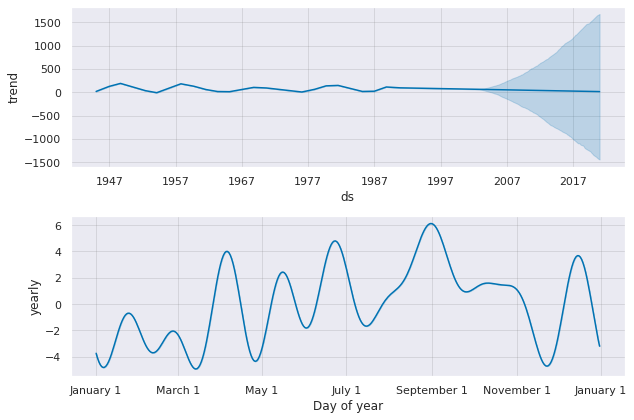

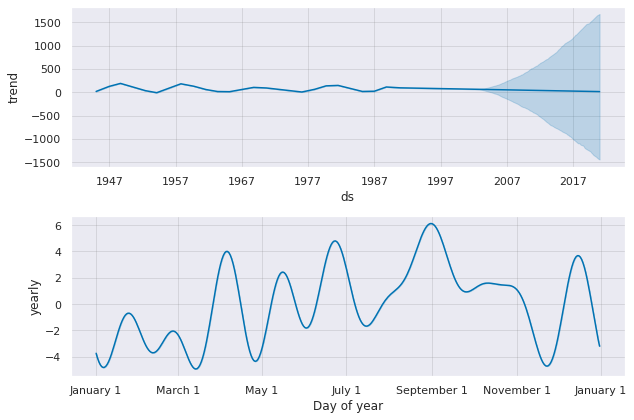

In [ ]:
model_prophet.plot_components(pred_prophet)

Если судить по метрикам, то получилось неплохо. На графике видно, что модель показывала вполне хорошие результаты на обучающей выборке и учитывала имеющуюся цикличность в данных до определенного момента. Затем результаты прогноза начали отклоняться от исторических данных. 

Среди параметров Prophet есть сезонность и периодичность. Заведем вспомогательную функцию и попробуем подобрать последний.

In [168]:
# Вспомогательная функция для построения прогноза по модели
def cycle_analysis(data, split_date, cycle, mode='additive', forecast_plot = False, print_ind=False):
    train_data = data[:split_date].iloc[:-1,]
    test_data = data[split_date:]
    pred_period = len(pd.date_range(split_date, max(data.index)))
    df = train_data.reset_index()
    df.columns = ['ds', 'y']

    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.add_seasonality('self_define_cycle', period=cycle, fourier_order=8, mode=mode)
    model.fit(df)

    future = model.make_future_dataframe(periods=pred_period, freq='d')
    forecast = model.predict(future)

    if forecast_plot:
        fig, ax = plt.subplots(1)
        fig.set_figheight(6)
        fig.set_figwidth(13)
        ax.scatter(test_data.index, test_data.values, color='r', s=10)
        ax.set_ylim([-100, 400])
        fig = model.plot(forecast, ax=ax)
        plt.xlabel('Date', fontsize=12, fontweight='bold', color='gray')
        plt.ylabel('Sunspots count', fontsize=12, fontweight='bold', color='gray')
        plt.show()

    ret = max(forecast.self_define_cycle) - min(forecast.self_define_cycle)
    model_tb = forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x: x.strftime("%Y-%m-%d"))
    out_tb = pd.concat([test_data, model_tb], axis=1)
    out_tb = out_tb[~out_tb.iloc[:, 0].isnull()]
    out_tb = out_tb[~out_tb.iloc[:, 1].isnull()]
    mse = mean_squared_error(out_tb.iloc[:, 0], out_tb.iloc[:, 1])
    mae = mean_absolute_error(out_tb.iloc[:, 0], out_tb.iloc[:, 1])
    rep = [ret, mse, mae]

    if print_ind:
#        print("Projected return per cycle: {}".format(round(rep[0], 2)))
        print('MSE = {0:.3f}, MAE = {1:.3f}'.format(round(rep[1], 4), round(rep[2], 4)));

    return rep

In [169]:
for mode in ['additive', 'multiplicative']:
    for i in np.arange(11, 12.1, 0.2):
        print('Mode: {0}, period: {1} days'.format(mode, round(365 * i)))
        cycle_analysis(data=data[['Time', 'Ra']].set_index('Time'), 
                       split_date=datetime.datetime(2002, 1, 1), 
                       cycle=round(365 * i), mode=mode, 
                       forecast_plot=False, print_ind=True)

Mode: additive, period: 4015 days
MSE = 1416.159, MAE = 28.014
Mode: additive, period: 4088 days
MSE = 1516.362, MAE = 29.383
Mode: additive, period: 4161 days
MSE = 1773.005, MAE = 32.700
Mode: additive, period: 4234 days
MSE = 2258.360, MAE = 38.693
Mode: additive, period: 4307 days
MSE = 2651.617, MAE = 42.966
Mode: additive, period: 4380 days
MSE = 2589.912, MAE = 42.537
Mode: multiplicative, period: 4015 days
MSE = 1085.126, MAE = 24.760
Mode: multiplicative, period: 4088 days
MSE = 1032.268, MAE = 25.781
Mode: multiplicative, period: 4161 days
MSE = 1217.677, MAE = 29.607
Mode: multiplicative, period: 4234 days
MSE = 1625.247, MAE = 35.468
Mode: multiplicative, period: 4307 days
MSE = 1593.458, MAE = 35.883
Mode: multiplicative, period: 4380 days
MSE = 2057.809, MAE = 41.120


Теперь обучим модель на параметрах, на которых достигается наилучший результат по метрикам: `MSE = 1032.268, MAE = 25.781`.


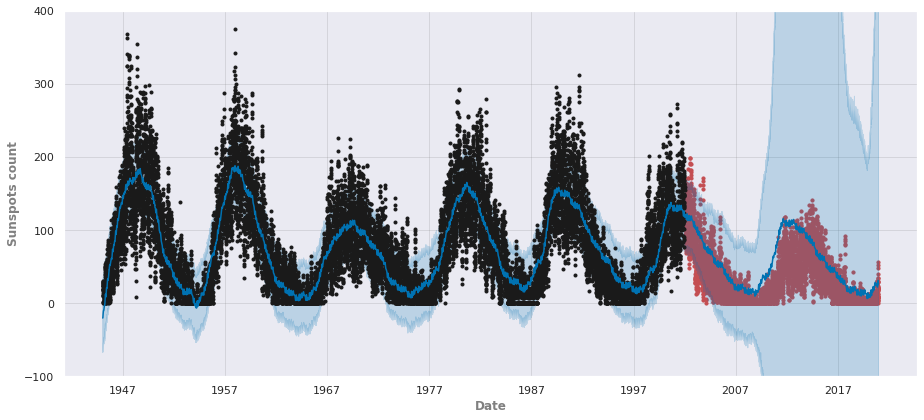

MSE = 1032.268, MAE = 25.781


In [179]:
output = cycle_analysis(data=data[['Time', 'Ra']].set_index('Time'), 
                        split_date=datetime.datetime(2002, 1, 1), 
                        cycle=4088, mode='multiplicative', 
                        forecast_plot=True, print_ind=True);

In [184]:
mse_prophet, mae_prophet = output[1], output[2]

Теперь сведем в единую таблицу полученные результаты.

In [185]:
models_mse = {'AutoReg': mse_AR, 'ARIMA': mse_ARIMA, 'SARIMA': mse_ARIMA, 'Prophet': mse_prophet}
models_mae = {'AutoReg': mae_AR, 'ARIMA': mae_ARIMA, 'SARIMA': mae_ARIMA, 'Prophet': mae_prophet}

In [193]:
result = pd.concat([pd.DataFrame([models_mse, models_mae]), 
                    pd.DataFrame(['MSE', 'MAE'], columns={'Type'})], 
                   axis=1)
result.set_index('Type')

,AutoReg,ARIMA,SARIMA,Prophet
Type,,,,
MSE,1899.903041,3760.238331,3760.238331,1032.267716
MAE,38.168630,55.776033,55.776033,25.781138


Из приведенной таблицы видно, что наилучшие метрики среди рассмотренных моделей у Prophet. Обучим эту модель на всей выборке и сделаем предсказание на заданное число дней вперед.

In [205]:
DAYS_TO_PREDICT = 30    # На сколько дней вперед необходимо выполнить предсказание

In [198]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality('self_define_cycle', period=4088, fourier_order=8, mode='multiplicative');

In [199]:
%%time
model.fit(data_prophet)

CPU times: user 2min 50s, sys: 560 ms, total: 2min 50s
Wall time: 2min 50s


In [206]:
future = model.make_future_dataframe(periods=DAYS_TO_PREDICT, freq='d')
predictions = model.predict(future)

In [207]:
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(DAYS_TO_PREDICT)

,ds,yhat,yhat_lower,yhat_upper
27759,2021-01-01,9.957138,-29.512657,50.656659
27760,2021-01-02,9.832951,-31.218427,50.660492
27761,2021-01-03,9.763827,-35.336361,46.798965
27762,2021-01-04,9.749690,-30.559333,48.402367
27763,2021-01-05,9.789062,-31.102755,49.392655
27764,2021-01-06,9.879122,-30.445768,49.204783
27765,2021-01-07,10.015800,-31.582656,50.770112
27766,2021-01-08,10.193903,-29.460916,50.179172
27767,2021-01-09,10.407267,-30.417695,53.496021
27768,2021-01-10,10.648939,-31.300560,50.547353


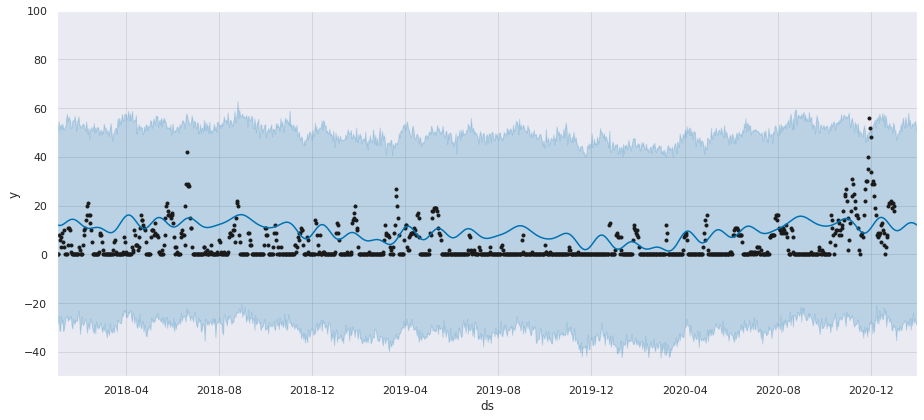

In [220]:
fig, ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(13)
ax.set_xlim([datetime.datetime(2018, 1, 1), datetime.datetime(2021, 1, 30)])
ax.set_ylim([-50, 100])
fig = model.plot(predictions, ax=ax)

#### Рекуррентная сеть (RNN)

Для прогнозирования временных рядов также можно использовать нейронные сети, например, рекуррентные.

В этом случае, весь объем выборки разбивается на небольшие последовательности, а прогнозу подлежат расположенные за такими наборами отдельные точки. Соответственно, задаваясь размером такого "окна" и последовательно смещая его, можно предсказывать целевые точки.

In [221]:
SEQ_LENGTH = 10 # Длина последовательности

In [222]:
# Вспомогательная функция, преобразующая исходный набор данных в набор последовательностей
def create_sequences(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

Для ускорения обучения выполним масштабирование данных. Для этого воспользуемся встроенной в `sklearn` функцией `MixMaxScaler`
.

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(train)

train_data = scaler.transform(train)
test_data = scaler.transform(test)

In [ ]:
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([20807, 10, 1]),
 torch.Size([20807, 1]),
 torch.Size([6929, 10, 1]),
 torch.Size([6929, 1]))

In [ ]:
train_data[:10]

array([[0.        ],
       [0.00266667],
       [0.00533333],
       [0.02933333],
       [0.04533333],
       [0.06933333],
       [0.05333333],
       [0.05066667],
       [0.048     ],
       [0.072     ]])

Опишем класс нашей модели на основе рекуррентной сети, унаследовавшись от стандартной `torch.nn.Module`.

In [ ]:
# Класс модели RNN
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=2, output_size=1):
        """
        В конструкторе нашего класса инициализируются параметры, которые затем передаются в слои сети - рекурретный LSTM и линейный на выходе.
        """
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            dropout=0.5,
            batch_first=True
            )
        
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, input):
        hidden = (
            torch.zeros(self.num_layers, input.size(0), self.hidden_size),
            torch.zeros(self.num_layers, input.size(0), self.hidden_size)
        )

        lstm_out, hidden = self.lstm(input, hidden)
        prediction = self.fc(hidden[0].view(-1, self.hidden_size))
        
        return prediction

In [ ]:
# Рутина обучения модели
def train_model(model, train_data, train_labels, 
                test_data=None, test_labels=None, 
                epochs=100, learning_rate=1e-3):

    criterion = nn.MSELoss(reduction='sum')
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)

    train_hist = []
    test_hist = []
    for epoch in range(epochs):

        y_pred = model(train_data)
        loss = criterion(y_pred, train_labels)
        train_hist.append(loss.item())

        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(test_data)
                test_loss = criterion(y_test_pred, test_labels)
            test_hist.append(test_loss.item())

            if (epoch + 1) % 10 == 0:  
                print('Epoch {0}:\ttrain_loss = {1}\ttest_loss = {2}'.format(epoch + 1, np.mean(train_hist[-10:]), np.mean(test_hist[-10:])))

        elif (epoch + 1) % 10 == 0:
            print('Epoch {0}:\ttrain_loss = {1}'.format(epoch + 1, np.mean(train_hist[-10:])))  

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
  
    return model.eval(), train_hist, test_hist

In [ ]:
EPOCHS = 150            # Кол-во эпох обучения
LEARNING_RATE = 1e-2    # Шаг обучения
INPUT_SIZE = 1
HIDDEN_SIZE = 32        # Размер скрытого слоя
NUM_LAYERS = 1          
NUM_CLASSES = 1         # Число классов на выходе

In [ ]:
model_RNN = RNN(input_size=INPUT_SIZE, 
                hidden_size=HIDDEN_SIZE, 
                num_layers=NUM_LAYERS, 
                output_size=NUM_CLASSES)

output = train_model(model_RNN, 
                     X_train, y_train, 
                     X_test, y_test, 
                     epochs=EPOCHS, 
                     learning_rate=LEARNING_RATE)

model_RNN, train_hist, test_hist = output

Epoch 10:	train_loss = 762.5913665771484	test_loss = 181.1667594909668
Epoch 20:	train_loss = 398.8166107177734	test_loss = 101.62927017211913
Epoch 30:	train_loss = 161.32127304077147	test_loss = 36.8961350440979
Epoch 40:	train_loss = 95.1407859802246	test_loss = 14.483680915832519
Epoch 50:	train_loss = 71.43270530700684	test_loss = 12.735065603256226
Epoch 60:	train_loss = 58.71940994262695	test_loss = 6.403238821029663
Epoch 70:	train_loss = 51.3380241394043	test_loss = 6.698561763763427
Epoch 80:	train_loss = 46.338218688964844	test_loss = 5.311502456665039
Epoch 90:	train_loss = 42.73488540649414	test_loss = 4.982507562637329
Epoch 100:	train_loss = 39.84914703369141	test_loss = 4.588575839996338
Epoch 110:	train_loss = 37.42762794494629	test_loss = 4.282352924346924
Epoch 120:	train_loss = 35.34183235168457	test_loss = 3.9847177505493163
Epoch 130:	train_loss = 33.56706314086914	test_loss = 3.7293607711791994
Epoch 140:	train_loss = 32.11715679168701	test_loss = 3.4951936721801

In [ ]:
model_RNN.parameters

<bound method Module.parameters of RNN(
  (lstm): LSTM(1, 32, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)>

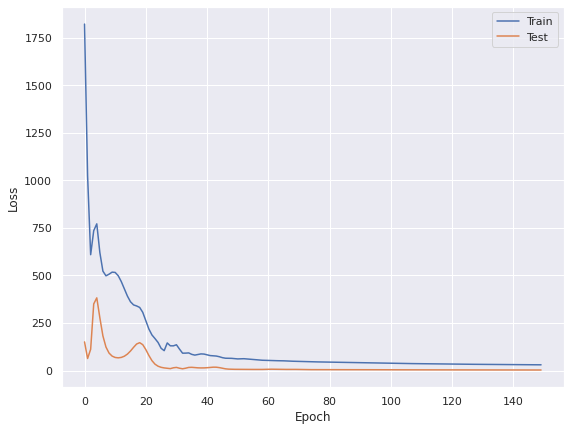

In [ ]:
sns.set(rc={'figure.figsize': (9, 7)})
plt.plot(train_hist, label="Train")
plt.plot(test_hist, label="Test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
test_pred = model_RNN(X_test)
pred_RNN = test_pred.data.numpy()
pred_RNN = scaler.inverse_transform(pred_RNN)

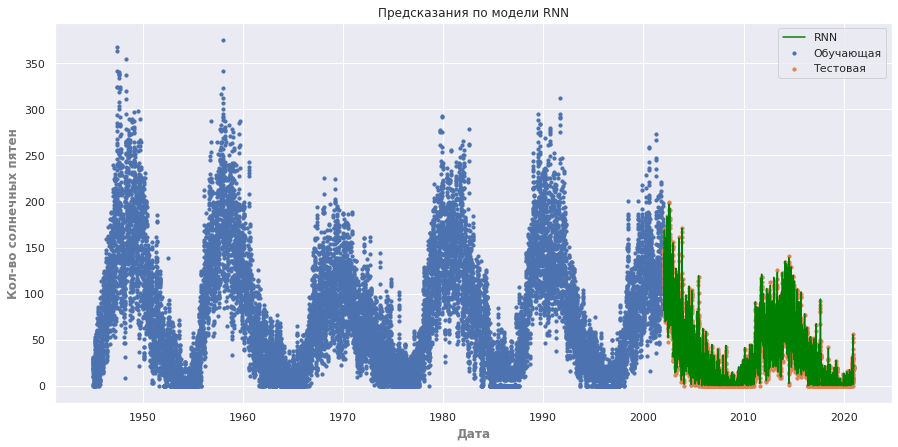

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(7)
fig.set_figwidth(15)
ax.scatter(train.index, train['Ra'], s=10, label='Обучающая')
ax.scatter(test.index, test['Ra'], s=10, label='Тестовая')
ax.plot(test[(seq_length+1):].index, pred_RNN, c='green', label='RNN')
plt.legend(loc='best') 
plt.title("Предсказания по модели RNN") 
plt.xlabel('Дата', fontsize=12, fontweight='bold', color='gray')
plt.ylabel('Кол-во солнечных пятен', fontsize=12, fontweight='bold', color='gray');

In [ ]:
mse_RNN = mean_squared_error(test[(seq_length+1):], pred_RNN, squared=True)
mae_RNN= mean_absolute_error(test[(seq_length+1):], pred_RNN)
print('MSE = {0:.3f}, MAE = {1:.3f}'.format(mse_RNN, mae_RNN));

MSE = 155.359, MAE = 8.600


Теперь обучим модель на всей выборке.

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(X)
all_data = scaler.transform(X)

In [ ]:
X_all, y_all = create_sequences(all_data, SEQ_LENGTH)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

In [ ]:
model_RNN = RNN(input_size=INPUT_SIZE, 
                hidden_size=HIDDEN_SIZE, 
                num_layers=NUM_LAYERS, 
                output_size=NUM_CLASSES)

model_RNN, train_hist, _ = train_model(model_RNN, 
                                       X_all, y_all, 
                                       epochs=EPOCHS, 
                                       learning_rate=LEARNING_RATE)

Epoch 10:	train_loss = 600.1696960449219
Epoch 20:	train_loss = 167.04469604492186
Epoch 30:	train_loss = 107.53139877319336
Epoch 40:	train_loss = 81.57212295532227
Epoch 50:	train_loss = 68.7417999267578
Epoch 60:	train_loss = 59.62900581359863
Epoch 70:	train_loss = 53.14604721069336
Epoch 80:	train_loss = 48.25260581970215
Epoch 90:	train_loss = 44.650499725341795
Epoch 100:	train_loss = 41.736698913574216
Epoch 110:	train_loss = 39.22172660827637
Epoch 120:	train_loss = 37.172146224975585
Epoch 130:	train_loss = 35.65642471313477
Epoch 140:	train_loss = 34.59654083251953
Epoch 150:	train_loss = 33.80237808227539


Теперь сделаем предсказание на заданное число дней вперед.

In [ ]:
DAYS_TO_PREDICT = 15    # На сколько дней вперед необходимо выполнить предсказание
with torch.no_grad():
    test_seq = X_all[:1]
    pred_RNN = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model_RNN(test_seq)
        pred = torch.flatten(y_test_pred).item()
        pred_RNN.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
test_seq

tensor([[[0.0548],
         [0.0577],
         [0.0604],
         [0.0630],
         [0.0656],
         [0.0680],
         [0.0704],
         [0.0728],
         [0.0752],
         [0.0777]]])

In [ ]:
pred_RNN = scaler.inverse_transform(
    np.expand_dims(pred_RNN, axis=0)
).flatten()

In [ ]:
X.index[-1]

Timestamp('2020-12-31 00:00:00')

In [ ]:
pred_index = pd.date_range(
    start=X.index[-1],
    periods=DAYS_TO_PREDICT + 1,
    closed='right'
)

In [ ]:
sunspots_RNN = pd.DataFrame(index=pred_index, data=pred_RNN, columns={'Prediction'})

In [ ]:
sunspots_RNN

,Prediction
2021-01-01,17.740304
2021-01-02,17.331585
2021-01-03,17.701649
2021-01-04,18.502755
2021-01-05,19.498704
2021-01-06,20.559099
2021-01-07,21.619669
2021-01-08,22.653054
2021-01-09,23.639747
2021-01-10,24.581926


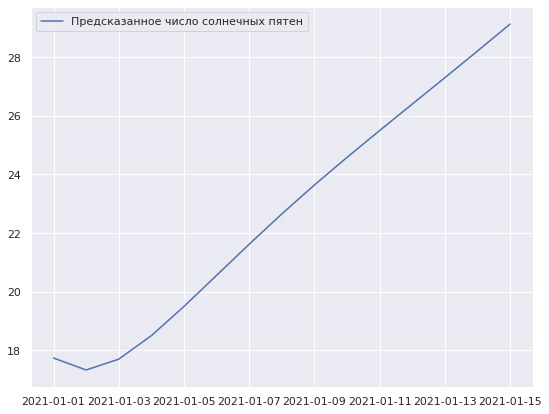

In [ ]:
sns.set(rc={'figure.figsize': (9, 7)})
plt.plot(sunspots_RNN, label='Предсказанное число солнечных пятен')
plt.legend();

Визуализируем полученные результаты.

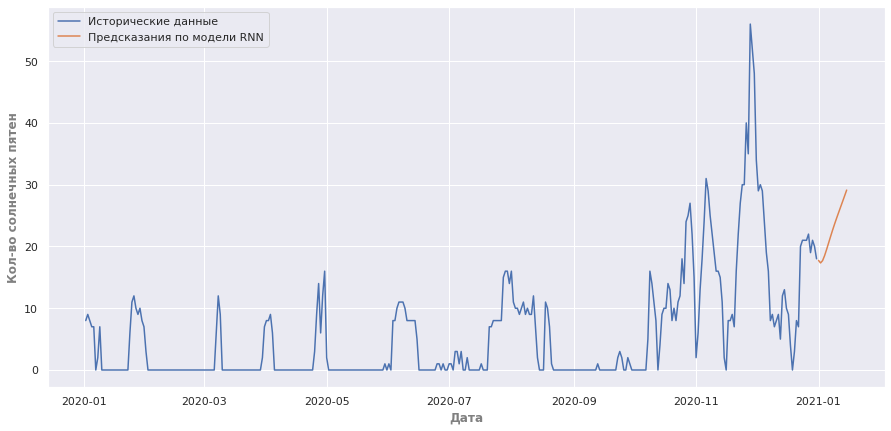

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(7)
fig.set_figwidth(15)
ax.plot(X[-365:], label='Исторические данные')
ax.plot(sunspots_RNN, label='Предсказания по модели RNN')
plt.legend(loc='best') 
plt.xlabel('Дата', fontsize=12, fontweight='bold', color='gray')
plt.ylabel('Кол-во солнечных пятен', fontsize=12, fontweight='bold', color='gray');